# Automatic comparison of STIX and AIA images

The aim of this script is to take as input the FITS files with STIX images and then downloading, processing and doing cutout of AIA 1600 or AIA 1700 images

This code is thought to be working with the REPROJ virtual environment

### Imports and functions

In [1]:
import astropy.units as u
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from aiapy.calibrate import fix_observer_location, normalize_exposure, register, update_pointing
from astropy.coordinates import SkyCoord
from astropy.time import Time

from sunpy.coordinates import Helioprojective
from sunpy.coordinates.ephemeris import get_earth
from sunpy.coordinates.frames import HeliocentricEarthEcliptic, HeliographicStonyhurst
from sunpy.map import Map, all_coordinates_from_map, make_fitswcs_header
from sunpy.net import attrs as a
from sunpy.net import Fido

In [2]:
plt.rcParams.update({'font.size': 14})

In [3]:
def download_aia(peak_time, wavelength, email, prep = True,
                           folder_store=''):
    """
    Download the AIA map
    """

    # JSOC email
    #jsoc_email = os.environ[email]

    # Define starting and ending time of the interval
    # for searching the AIA map (default 12 seconds)
    dt = 12
    time_start = Time(peak_time)-dt*u.s
    time_end = Time(peak_time)+dt*u.s

    # Search for the data
    query = Fido.search(#a.Instrument.aia,
                    #a.Physobs.intensity,
                    #a.jsoc.Series.aia_lev1_uv_24s,
                    #a.jsoc.Notify(jsoc_email),
                    #a.jsoc.Segment.image,
                    #a.Wavelength(wavelength*u.angstrom),
                    #a.Time(time_start, time_end)
                    a.Time(time_start, time_end),
                    a.Wavelength(wavelength*u.angstrom),
                    a.Sample(48*u.s),
                    a.jsoc.Series.aia_lev1_uv_24s,
                    a.jsoc.Notify(email),
                    a.jsoc.Segment.image,
                    )
    
    # Download the data
    file_downloaded = Fido.fetch(query[0][0], path=folder_store)
    #if file_downloaded == []:
    #    print('No data found. We try to download the data from ROB now...')
    #    file_downloaded = Fido.fetch(query[0][0], site='ROB', path=folder_store)
    map = Map(file_downloaded)

    # If perp == True, then process the map
    if prep == True:
        map = process_aia(map)

    return map

In [4]:
def process_aia(map):
    """
    Process the AIA map to level 1.5 and
    update the pointing information in the header.
    """

    # Calibrate the map
    map = register(update_pointing(map))
    map = normalize_exposure(map)
    map = fix_observer_location(map)

    return map

In [5]:
def reproject_aia2so(aia_map, stix_map, out_shape = (1024, 1024)):
    """
    Reproject the AIA map to the Solar Orbiter view
    """

    # Get the coordinates of the center of the STIX map in arcsec
    all_coords = all_coordinates_from_map(stix_map)
    # get the coordinates of the center of the map
    center = SkyCoord(all_coords.Tx.mean(), all_coords.Ty.mean(), frame=stix_map.coordinate_frame)
    mapcenter = [center.Tx.value, center.Ty.value]

    # Define the reference coordinate
    ref_coord = SkyCoord(
                     mapcenter[0]*u.arcsec, mapcenter[1]*u.arcsec,
                     #0*u.arcsec, 0*u.arcsec,
                     frame='helioprojective', 
                     obstime=stix_map.date, 
                     observer=stix_map.observer_coordinate)


    # Reference pixel in the AIA map
    #ref_pix = stix_map.world_to_pixel(center)

    # Distance AIA and SO to the Sun
    dist_aia = aia_map.observer_coordinate.radius.value
    dist_so  = stix_map.observer_coordinate.radius.value
    factor = dist_aia / dist_so
    pixel_size = [float(aia_map.scale[0]/u.arcsec*u.pixel) * factor, 
                  float(aia_map.scale[1]/u.arcsec*u.pixel) * factor]

    # Create a FITS WCS header for the reference coordinate and frame
    header = make_fitswcs_header(
        out_shape,
        ref_coord,
        scale = pixel_size*u.arcsec/u.pixel
        #reference_pixel = ref_pix*u.pix
        )

    # Reproject the AIA map
    map = aia_map.reproject_to(header)
    
    return map, mapcenter

In [6]:
def hgs2hpc(hsg_coord, date, observer):
    '''
    This function takes as an input the Heliographic Stonyhurts coordinates
    and returns the Helioprojective coordinates as observed by Earth.
     - hsg_coord must be a 2D array [lon (deg), lat (deg)]
     - date of the observation
     - observer must be the result of map.observer_coordinate (of an AIA map)
    '''

    # SkyCoord of the input coordinates
    hsg_skycoord = SkyCoord(hsg_coord[0]*u.deg, 
                            hsg_coord[1]*u.deg, 
                            #obstime=date,
                            frame=HeliographicStonyhurst(obstime=date))

    # Transform to Helioprojective cartesian
    hpc_coord = hsg_skycoord.transform_to(Helioprojective(obstime=date,
                                          observer=observer))

    return hpc_coord

### Parameters

In [62]:
# Folder containing the STIX maps
# folder_stix = '/home/afbattaglia/Documents/ETHZ/PhD/Codes/automatic_STIX-AIA_location_comparison/STIX-maps/'
folder_stix = '/net/galilei/work2/fschuller/data/STIX-maps/'
# working on sylvaner:
folder_stix = '/work2/fschuller/STIX/STIX-maps/'

# Folder where to store the reprojected AIA maps
# folder_store_rmaps = '/home/afbattaglia/Documents/ETHZ/PhD/Codes/automatic_STIX-AIA_location_comparison/AIA-rmaps/'
folder_store_rmaps = folder_stix+"AIA/"

# Folder where to store the AIA full-disk maps
# folder_store = '/home/afbattaglia/Documents/ETHZ/PhD/Codes/automatic_STIX-AIA_location_comparison/Data/SDO_AIA/full-disk/'
folder_store = folder_stix+"AIA/"

# Folder where to store the overview plots
# folder_plots = '/home/afbattaglia/Software/STIX_estimate_pointing_error/overview-images/'
folder_plots = folder_stix

# Email associated with the JSOC account
# Not registered yet? Go to: http://jsoc.stanford.edu/ajax/register_email.html
# email = 'andrea-battaglia@ethz.ch'
email = 'fschuller@aip.de'

# Wavelengths of the AIA maps to download
# wavelength = 1600
wavelength = 1700

# FOV of the AIA maps
fov = [400, 400]

# Final FOV of the reprojected AIA maps with STIX
fov_plot = [200, 200]

# Path to the Frederic's table
# frederic_csv = '/home/afbattaglia/Software/STIX_estimate_pointing_error/Flare-location_test-table.csv'

## Run one example

In [7]:
# Define variables of interest
peak_time_so = '2022-03-28T17:07'
uid          = '2203282347'
start_time_so = '2022-03-28T17:05:10'
end_time_so  = '2022-03-28T17:07:50'
energy_low   = 18.
energy_high  = 50.

# flare location as seen from Earth
flare_loc_earth_string = 'N13W07'


In [70]:
### Another example
peak_time_so = '2022-03-02T17:35'
uid          = '2203026385'
start_time_so = '2022-03-02T17:34:15'
end_time_so  = '2022-03-02T17:34:40'
energy_low   = 15.
energy_high  = 28.
flare_loc_earth_string = 'N15E29'


In [46]:
def flare_coord_to_float(coord_string):
    # Convert the flare coordinates from string to 2 float values
    sign_ns = 1
    sign_ew = 1
    if coord_string[0] == 'S': sign_ns = -1
    if coord_string[3] == 'E': sign_ew = -1
    coord_ns = float(coord_string[1:3])
    coord_ew = float(coord_string[4:6])
    lon = (sign_ew * coord_ew) #* u.deg
    lat = (sign_ns * coord_ns) #* u.deg
    return (lon,lat)
    # print("Flare location: %3i , %3i"%(lon,lat))


In [51]:
def transform_HGS_to_HPC(coord, peak_time):
    # Transform the locations from HGS string to HPC coordinates
    # Get the Earth coordinates in hgs
    earth_hgs = get_earth(Time(peak_time).isot)

    # Transform the coordinates of the flare location from hgs to hpc
    hpc_coord = hgs2hpc([coord[0], coord[1]], peak_time, earth_hgs)

    # Store the coordinates
    flare_loc_earth_hpc = [hpc_coord.Tx.value,hpc_coord.Ty.value]
    # print("Helioprojective location: %7.1f , %7.1f"%(flare_loc_earth_hpc[0],flare_loc_earth_hpc[1]))
    
    return flare_loc_earth_hpc



In [98]:
def plot_aia_stix_overlay(uid, peak_time_so, start_time_so, end_time_so, 
                          energy_low, energy_high, flare_loc, wavelength=1700):
    # Open STIX map, download AIA map closest to peak time, re-project to STIX viewpoint,
    # and generate a plot showing the overlay of STIX on top
    stix_map_file = glob.glob(folder_stix + '*'+uid+'*.fits')
    print("Found STIX map:")
    print(stix_map_file)
    stix_map = Map(stix_map_file[0])
    
    # Get the light travel time correction from the FITS header
    ltt = stix_map.meta['EAR_TDEL']
    print('Light travel time correction: '+str(ltt)+' s')

    # Time at Earth
    time_earth = Time(peak_time_so) + ltt*u.s
    # Download the AIA map
    print("Downloading AIA image...")
    aia_map = download_aia(time_earth, wavelength, email, folder_store=folder_store)
    
    # modify the value for rsun in AIA map to match the one in STIX map
    aia_map.meta['rsun_ref'] = stix_map.meta['rsun_ref']

    # convert flare location to HPC coordinates
    coord = flare_coord_to_float(flare_loc)
    flare_loc_earth_hpc = transform_HGS_to_HPC(coord, peak_time_so)

    # Extract the submap according to the flare location as seen from Earth
    bottom_left = SkyCoord((flare_loc_earth_hpc[0]-fov[0]/2)*u.arcsec,
                       (flare_loc_earth_hpc[1]-fov[1]/2)*u.arcsec,
                       frame=aia_map.coordinate_frame)
    top_right = SkyCoord((flare_loc_earth_hpc[0]+fov[0]/2)*u.arcsec,
                     (flare_loc_earth_hpc[1]+fov[1]/2)*u.arcsec,
                     frame=aia_map.coordinate_frame)
    submap = aia_map.submap(bottom_left, top_right=top_right)
    
    # Reproject the AIA map to the STIX view
    rmap_aia, stix_center = reproject_aia2so(submap, stix_map)

    # Save the reprojected map
    rmap_aia.save(folder_store_rmaps+'reprojected-AIA'+str(wavelength)+'_'+str(peak_time_so)+'_'+str(uid)+'.fits')

    # Select sub-maps covering the same region with both instruments
    bottom_left_plot = SkyCoord((stix_center[0]-fov_plot[0]/2)*u.arcsec,
                            (stix_center[1]-fov_plot[1]/2)*u.arcsec,
                            frame=rmap_aia.coordinate_frame)
    top_right_plot = SkyCoord((stix_center[0]+fov_plot[0]/2)*u.arcsec,
                          (stix_center[1]+fov_plot[1]/2)*u.arcsec,
                          frame=rmap_aia.coordinate_frame)
    sub_rmap_aia = rmap_aia.submap(bottom_left_plot, top_right=top_right_plot)
    sub_stix_map = stix_map.submap(bottom_left_plot, top_right=top_right_plot)

    # Here comes the plot
    fig = plt.figure(figsize=(10,10), dpi=100, facecolor='white')
    ax = plt.subplot(projection=sub_rmap_aia)
    sub_rmap_aia.plot(axes=ax)
    sub_stix_map.draw_contours([30,50,70,90]*u.pct, axes=ax, colors='black')
    lon = ax.coords[0]
    lon.display_minor_ticks(True)
    lat = ax.coords[1]
    lat.display_minor_ticks(True)
    lon.grid(color='black', alpha=1, linestyle='solid')
    lat.grid(color='black', alpha=1, linestyle='solid')
    ax.set_title(aia_map.meta['date-obs']+'   Earth UT')


    # Add some text caption
    x_txt = 0.04
    y_txt = 0.96
    dy = 0.03

    ax.text(x_txt, y_txt, 'Data request UID: '+str(uid),
            verticalalignment='top', horizontalalignment='left',
            transform=ax.transAxes,
            color='blue', fontsize=15)
    ax.text(x_txt, y_txt-dy, 'Time range (SO UT): '+start_time_so+' - '+end_time_so,
            verticalalignment='top', horizontalalignment='left',
            transform=ax.transAxes,
            color='blue', fontsize=15)
    ax.text(x_txt, y_txt-2*dy, 'Energy range (keV): %2s - %2s'%(energy_low,energy_high),
            verticalalignment='top', horizontalalignment='left',
            transform=ax.transAxes,
            color='blue', fontsize=15)

    # Export to PNG
    plt.savefig(folder_plots+'AIA'+str(wavelength)+'-STIX_'+str(peak_time_so)+'_'+str(uid)+'.png')
    

In [54]:
coord = flare_coord_to_float("S15W29")
p_time = '2022-03-02T17:35'
transform_HGS_to_HPC(coord, p_time)


[455.0698524574523, -146.1204400508332]

Found STIX map:
['/work2/fschuller/STIX/STIX-maps/2022-03-02T17:35_2203026385_mem.fits']
Light travel time correction: 217.555871633 s
Export request pending. [id=JSOC_20230726_3569, status=2]
Waiting for 0 seconds...
1 URLs found for download. Full request totalling 12MB


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia.lev1_uv_24s.2022-03-02T173829Z.1700.image_lev1.fits:   0%|          | 0.00/12.4M [00:00<?, ?B/s]

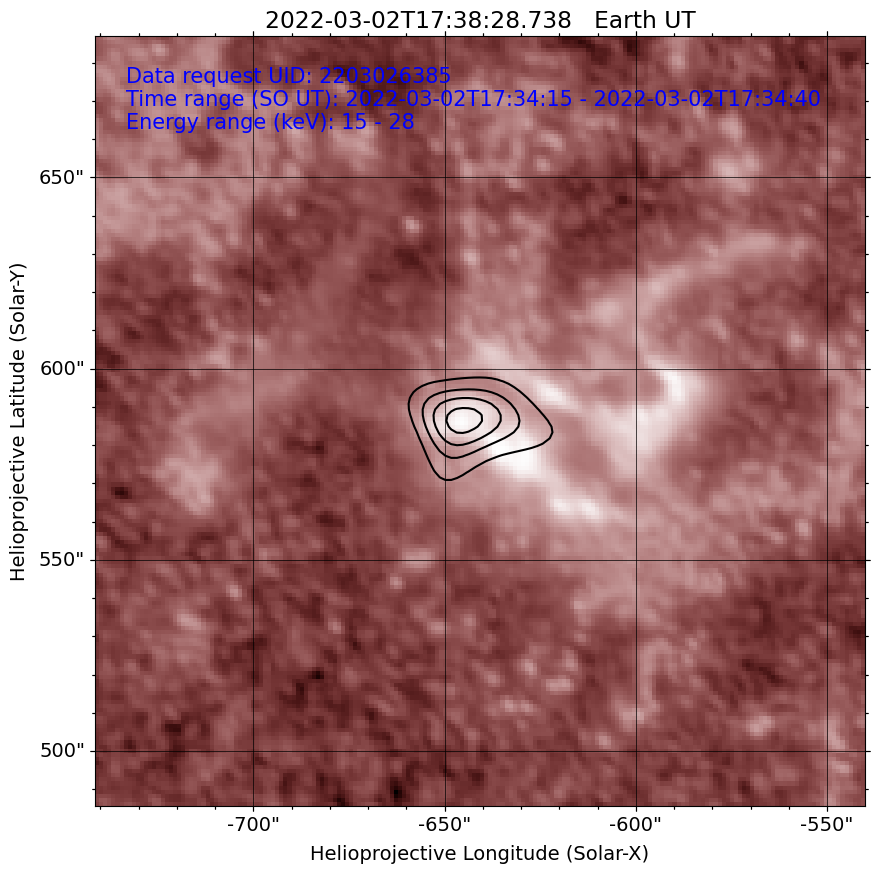

In [73]:
plot_aia_stix_overlay(uid, peak_time_so, start_time_so, end_time_so, energy_low, energy_high, flare_loc_earth_string)


## Loop over many (all) events

In [116]:
# Read file with all parameters
input_csv = '/home/fschuller/Documents/SolarOrb/Flare_location_SDO+STIX-imaging.csv'
df = pd.read_csv(input_csv, header=1)

df


,Peak time (UTC),GOES,SSW loc.,UID,t min,t max,E min,E max
0,2021-03-02T23:56,C1.2,S19E43,2103020009,2021-03-02T23:56:40,2021-03-02T23:58:10,4,15
1,2021-05-07T18:50,M3.9,N17E78,2105070034,2021-05-07T18:50:00,2021-05-07T19:09:00,15,28
2,2021-07-24T00:25,C4.3,S16E52,2107240003,2021-07-24T00:24:25,2021-07-24T00:27:30,10,25
3,2021-08-13T20:59,C1.4,N24E00,2108130003,2021-08-13T21:03:55,2021-08-13T21:05:55,4,20
4,2021-08-26T23:16,C3.9,S30E21,2108260029,2021-08-26T23:17:55,2021-08-26T23:19:35,20,28
...,...,...,...,...,...,...,...,...
82,2023-03-17T15:03,M1.1,S22W66,,,,,
83,2023-03-22T23:16,(B8),,2303223740,2023-03-22T23:15:43,2023-03-22T23:17:04,8,15
84,2023-03-29T13:59,M1.3,S21W67,,,,,
85,2023-03-29T23:40,M1.2,S20W72,,,,,


In [117]:
# Store variables of interests
peak_times_so = list(df.iloc[:,0])
flare_loc_earth_string = list(df.iloc[:,2])
uid = list(df.iloc[:,3])
start_time_so = list(df.iloc[:,4])
end_time_so = list(df.iloc[:,5])
energy_low  = list(df.iloc[:,6])
energy_high = list(df.iloc[:,7])


In [131]:
i = 64
this_uid = uid[i][1:]
e_low  = energy_low[i][1:]
e_high = energy_high[i][1:]
this_flare_loc = flare_loc_earth_string[i][1:]

if this_uid != '' and e_low != '' and this_flare_loc != 'xxx':
    print ("go go")
    print (peak_times_so[i], flare_loc_earth_string[i])

    

go go
2023-02-07T23:06  N30E03


In [ ]:
plot_aia_stix_overlay(this_uid, peak_times_so[i], start_time_so[i], end_time_so[i],
                      e_low, e_high, this_flare_loc)



In [ ]:
#for i in range(len(uid)):
# start again at i=10 (there was a bug in my test)
#for i in range(10,len(uid)):
# and again at i=65 (stopped to avoid overwriting some file)
# for i in range(65,len(uid)):

# did not find any AIA data for i=67 (?!), thus:

for i in range(68,len(uid)):
    # Get the parameters for the current flare
    this_uid = uid[i][1:]
    this_peak_time = peak_times_so[i]
    start_time = start_time_so[i][1:]
    end_time   = end_time_so[i][1:]
    e_low  = energy_low[i][1:]
    e_high = energy_high[i][1:]
    this_flare_loc = flare_loc_earth_string[i][1:]

    if this_uid != '' and e_low != '' and this_flare_loc != 'xxx':
        plot_aia_stix_overlay(this_uid, this_peak_time, start_time, end_time, e_low, e_high, this_flare_loc)


In [129]:
print(i,len(uid))


83 87


# The end...

In [ ]:
fig = plt.figure(figsize=(10,10), dpi=100, facecolor='white')
ax = plt.subplot(projection=sub_rmap_aia)
sub_rmap_aia.plot(axes=ax)
sub_stix_map.draw_contours([30,50,70,90]*u.pct, axes=ax, colors='black')
lon = ax.coords[0]
lon.display_minor_ticks(True)
lat = ax.coords[1]
lat.display_minor_ticks(True)
lon.grid(color='black', alpha=1, linestyle='solid')
lat.grid(color='black', alpha=1, linestyle='solid')
ax.set_title(aia_map.meta['date-obs']+'   Earth UT')


# Add some text caption
x_txt = 0.04
y_txt = 0.96
dy = 0.03

ax.text(x_txt, y_txt, 'Data request UID: '+str(uid),
            verticalalignment='top', horizontalalignment='left',
            transform=ax.transAxes,
            color='blue', fontsize=15)
ax.text(x_txt, y_txt-dy, 'Time range (SO UT): '+start_time_so+' - '+end_time_so,
            verticalalignment='top', horizontalalignment='left',
            transform=ax.transAxes,
            color='blue', fontsize=15)
ax.text(x_txt, y_txt-2*dy, 'Energy range (keV): %2i - %2i'%(energy_low,energy_high),
            verticalalignment='top', horizontalalignment='left',
            transform=ax.transAxes,
            color='blue', fontsize=15)
#ax.text(x_txt, y_txt-3*dy, 'Contour levels: [50,70,90]%',
#            verticalalignment='top', horizontalalignment='left',
#            transform=ax.transAxes,
#            color='black', fontsize=15)
#ax.text(x_txt, y_txt-4*dy, 'Algorithm: MEM_GE',
#            verticalalignment='top', horizontalalignment='left',
#            transform=ax.transAxes,
#            color='black', fontsize=15)

### Main code from Andrea (loop over all events)

In [ ]:
# Get the list of STIX maps
list_stix = glob.glob(folder_stix+'*')
list_stix.sort()
list_stix

In [9]:
# Number of STIX maps
n_stix_maps = len(list_stix)

In [ ]:
# Open Frederic's table to get the flare locations as seen from Earth
df = pd.read_csv(frederic_csv)

# Store variables of interests
peak_times_so = list(df.iloc[1:,0])
flare_loc_earth_string = list(df.iloc[1:,2])
uid = list(df.iloc[1:,3])
start_time_so = list(df.iloc[1:,4])
end_time_so = list(df.iloc[1:,5])
energy_low  = list(df.iloc[1:,6])
energy_high = list(df.iloc[1:,7])

flare_loc_earth_string, uid

In [ ]:
# Number of flares
nflares = len(flare_loc_earth_string)
nflares

In [12]:
# Transform the locations from HGS string to HPC coordinates
### This should be done by looping on the STIX maps,
### once we have all UIDs associated with each map
flare_loc_earth_hpc = np.zeros([nflares, 2])
for i in range(nflares):

    # Convert the coordinate from string to a 2D array
    sign_ns = 1
    sign_ew = 1
    if flare_loc_earth_string[i][0] == 'S': sign_ns = -1
    if flare_loc_earth_string[i][3] == 'E': sign_ew = -1
    coord_ns = float(flare_loc_earth_string[i][1:3])
    coord_ew = float(flare_loc_earth_string[i][4:6])
    lon = (sign_ew * coord_ew) #* u.deg
    lat = (sign_ns * coord_ns) #* u.deg

    #print(lon, lat)
    #print(coord_ew, coord_ns)

    # Get the Earth coordinates in hgs
    earth_hgs = get_earth(Time(peak_times_so[i]).isot)

    # Transform the coordinates of the flare location from hgs to hpc
    hpc_coord = hgs2hpc([lon, lat], peak_times_so[i], earth_hgs)

    # Store the coordinates
    flare_loc_earth_hpc[i,0] = hpc_coord.Tx.value
    flare_loc_earth_hpc[i,1] = hpc_coord.Ty.value

In [ ]:
flare_loc_earth_hpc

In [14]:
# Export figure to png file
plt.savefig(folder_plots+'AIA'+str(wavelength)+'-STIX_'+str(this_peak_time)+'_'+str(this_uid)+'.png')
plt.close()


In [15]:
# Loop on all flares in the list
for this_el in range(nflares):

    # Get the variables of the current flare
    this_uid = uid[this_el]
    this_peak_time = peak_times_so[this_el]
    this_flare_loc_earth_hpc = flare_loc_earth_hpc[this_el,:]
    this_time_range = [start_time_so[this_el], end_time_so[this_el]]
    this_energy_range = [energy_low[this_el], energy_high[this_el]]
    
    print()
    print('Flare ID: '+str(this_uid))
    print()

    # Find the STIX map containing this_uid
    for this_map in range(n_stix_maps):
        if this_uid in list_stix[this_map]:
            this_stix_map = list_stix[this_map]
            break

    # Open the first STIX map
    stix_map = Map(this_stix_map)

    # Get the light travel time correction from the FITS header
    ltt = stix_map.meta['EAR_TDEL']
    #print('Light travel time correction: '+str(ltt)+' s')

    # Time at Earth
    time_earth = Time(this_peak_time) + ltt*u.s

    # Download the AIA map
    aia_map = download_aia(time_earth, wavelength, email, folder_store=folder_store)

    # Data providers can set the radius at which emission in the map is 
    # assumed to have come from. Most maps use a default value for 
    # photospheric radius, but some maps (as AIA maps) are set to a slightly 
    # different value. A mismatch in solar radius means a reprojection will 
    # not work correctly on pixels near the limb. This can be prevented by 
    # modifying the values for rsun on one map to match the other.
    aia_map.meta['rsun_ref'] = stix_map.meta['rsun_ref']

    # Extract the submap according to the flare location as seen from Earth
    bottom_left = SkyCoord((this_flare_loc_earth_hpc[0]-fov[0]/2)*u.arcsec,
                           (this_flare_loc_earth_hpc[1]-fov[1]/2)*u.arcsec,
                            frame=aia_map.coordinate_frame)
    top_right = SkyCoord((this_flare_loc_earth_hpc[0]+fov[0]/2)*u.arcsec,
                         (this_flare_loc_earth_hpc[1]+fov[1]/2)*u.arcsec,
                          frame=aia_map.coordinate_frame)
    submap = aia_map.submap(bottom_left, top_right=top_right)

    # Reproject the AIA map to the STIX view
    rmap_aia, stix_center = reproject_aia2so(submap, stix_map)

    # Save the reprojected map
    rmap_aia.save(folder_store_rmaps+'reprojected-AIA'+str(wavelength)+'_'+str(this_peak_time)+'_'+str(this_uid)+'.fits')

    # PLOT
    bottom_left_plot = SkyCoord((stix_center[0]-fov_plot[0]/2)*u.arcsec,
                                (stix_center[1]-fov_plot[1]/2)*u.arcsec,
                                 frame=rmap_aia.coordinate_frame)
    top_right_plot = SkyCoord((stix_center[0]+fov_plot[0]/2)*u.arcsec,
                              (stix_center[1]+fov_plot[1]/2)*u.arcsec,
                               frame=rmap_aia.coordinate_frame)
    sub_rmap_aia = rmap_aia.submap(bottom_left_plot, top_right=top_right_plot)
    sub_stix_map = stix_map.submap(bottom_left_plot, top_right=top_right_plot)

    fig = plt.figure(figsize=(10,10), dpi=100, facecolor='white')
    ax = plt.subplot(projection=sub_rmap_aia)
    sub_rmap_aia.plot(axes=ax)
    sub_stix_map.draw_contours([50,70,90]*u.pct, axes=ax, colors='red')
    lon = ax.coords[0]
    lon.display_minor_ticks(True)
    lat = ax.coords[1]
    lat.display_minor_ticks(True)
    lon.grid(color='black', alpha=1, linestyle='solid')
    lat.grid(color='black', alpha=1, linestyle='solid')
    ax.set_title(aia_map.meta['date-obs']+'   Earth UT')

    ax.text(x_txt, y_txt, 'Flare ID: '+str(this_uid),
            verticalalignment='top', horizontalalignment='left',
            transform=ax.transAxes,
            color='red', fontsize=15)
    ax.text(x_txt, y_txt-dy, 'Time range (SO UT): '+this_time_range[0]+' - '+this_time_range[1],
            verticalalignment='top', horizontalalignment='left',
            transform=ax.transAxes,
            color='red', fontsize=15)
    ax.text(x_txt, y_txt-2*dy, 'Energy range (keV): '+this_energy_range[0]+' - '+this_energy_range[1],
            verticalalignment='top', horizontalalignment='left',
            transform=ax.transAxes,
            color='red', fontsize=15)
    ax.text(x_txt, y_txt-3*dy, 'Contour levels: [50,70,90]%',
            verticalalignment='top', horizontalalignment='left',
            transform=ax.transAxes,
            color='red', fontsize=15)
    ax.text(x_txt, y_txt-4*dy, 'Algorithm: MEM_GE',
            verticalalignment='top', horizontalalignment='left',
            transform=ax.transAxes,
            color='red', fontsize=15)

    plt.savefig(folder_plots+'AIA'+str(wavelength)+'-STIX_'+str(this_peak_time)+'_'+str(this_uid)+'.png')
    #plt.show()
    plt.close()


Flare ID: 2105070034

Export request pending. [id=JSOC_20230721_346, status=2]
Waiting for 0 seconds...
1 URLs found for download. Full request totalling 8MB


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]


Flare ID: 2109230075

Export request pending. [id=JSOC_20230721_360, status=2]
Waiting for 0 seconds...
1 URLs found for download. Full request totalling 8MB


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]


Flare ID: 2110090002

Export request pending. [id=JSOC_20230721_431, status=2]
Waiting for 0 seconds...
1 URLs found for download. Full request totalling 8MB


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]


Flare ID: 2201208962

Export request pending. [id=JSOC_20230721_434, status=2]
Waiting for 0 seconds...
1 URLs found for download. Full request totalling 8MB


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/home/afbattaglia/anaconda3/envs/reproj/lib/python3.11/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/afbattaglia/anaconda3/envs/reproj/lib/python3.11/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)



Flare ID: 2203026385

Export request pending. [id=JSOC_20230721_437, status=2]
Waiting for 0 seconds...
1 URLs found for download. Full request totalling 8MB


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]


Flare ID: 2203118542

Export request pending. [id=JSOC_20230721_438, status=2]
Waiting for 0 seconds...
1 URLs found for download. Full request totalling 8MB


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]


Flare ID: 2203143075

Export request pending. [id=JSOC_20230721_440, status=2]
Waiting for 0 seconds...
1 URLs found for download. Full request totalling 8MB


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]


Flare ID: 2203159015

Export request pending. [id=JSOC_20230721_442, status=2]
Waiting for 0 seconds...
1 URLs found for download. Full request totalling 8MB


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]


Flare ID: 2203159363

Export request pending. [id=JSOC_20230721_445, status=2]
Waiting for 0 seconds...
1 URLs found for download. Full request totalling 8MB


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]


Flare ID: 2203282437

Export request pending. [id=JSOC_20230721_446, status=2]
Waiting for 0 seconds...
1 URLs found for download. Full request totalling 8MB


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]


Flare ID: 2203293826

Export request pending. [id=JSOC_20230721_448, status=2]
Waiting for 0 seconds...
1 URLs found for download. Full request totalling 8MB


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]


Flare ID: 2204023786

Export request pending. [id=JSOC_20230721_449, status=2]
Waiting for 0 seconds...
1 URLs found for download. Full request totalling 8MB


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]


Flare ID: 2204176813

Export request pending. [id=JSOC_20230721_451, status=2]
Waiting for 0 seconds...
1 URLs found for download. Full request totalling 8MB


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]


Flare ID: 2204185406

Export request pending. [id=JSOC_20230721_452, status=2]
Waiting for 0 seconds...
1 URLs found for download. Full request totalling 8MB


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]


Flare ID: 2204184714

Export request pending. [id=JSOC_20230721_454, status=2]
Waiting for 0 seconds...
1 URLs found for download. Full request totalling 8MB


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]


Flare ID: 2208271589

Export request pending. [id=JSOC_20230721_457, status=2]
Waiting for 0 seconds...
1 URLs found for download. Full request totalling 8MB


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]